In [44]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [3]:
# drop id -- irrelevant feature
df = df.drop('id',axis=1)

In [4]:
df.dtypes

date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
df.shape

(21613, 20)

In [6]:
## method ref: https://www.kaggle.com/code/scratchpad/notebook91f4588400
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

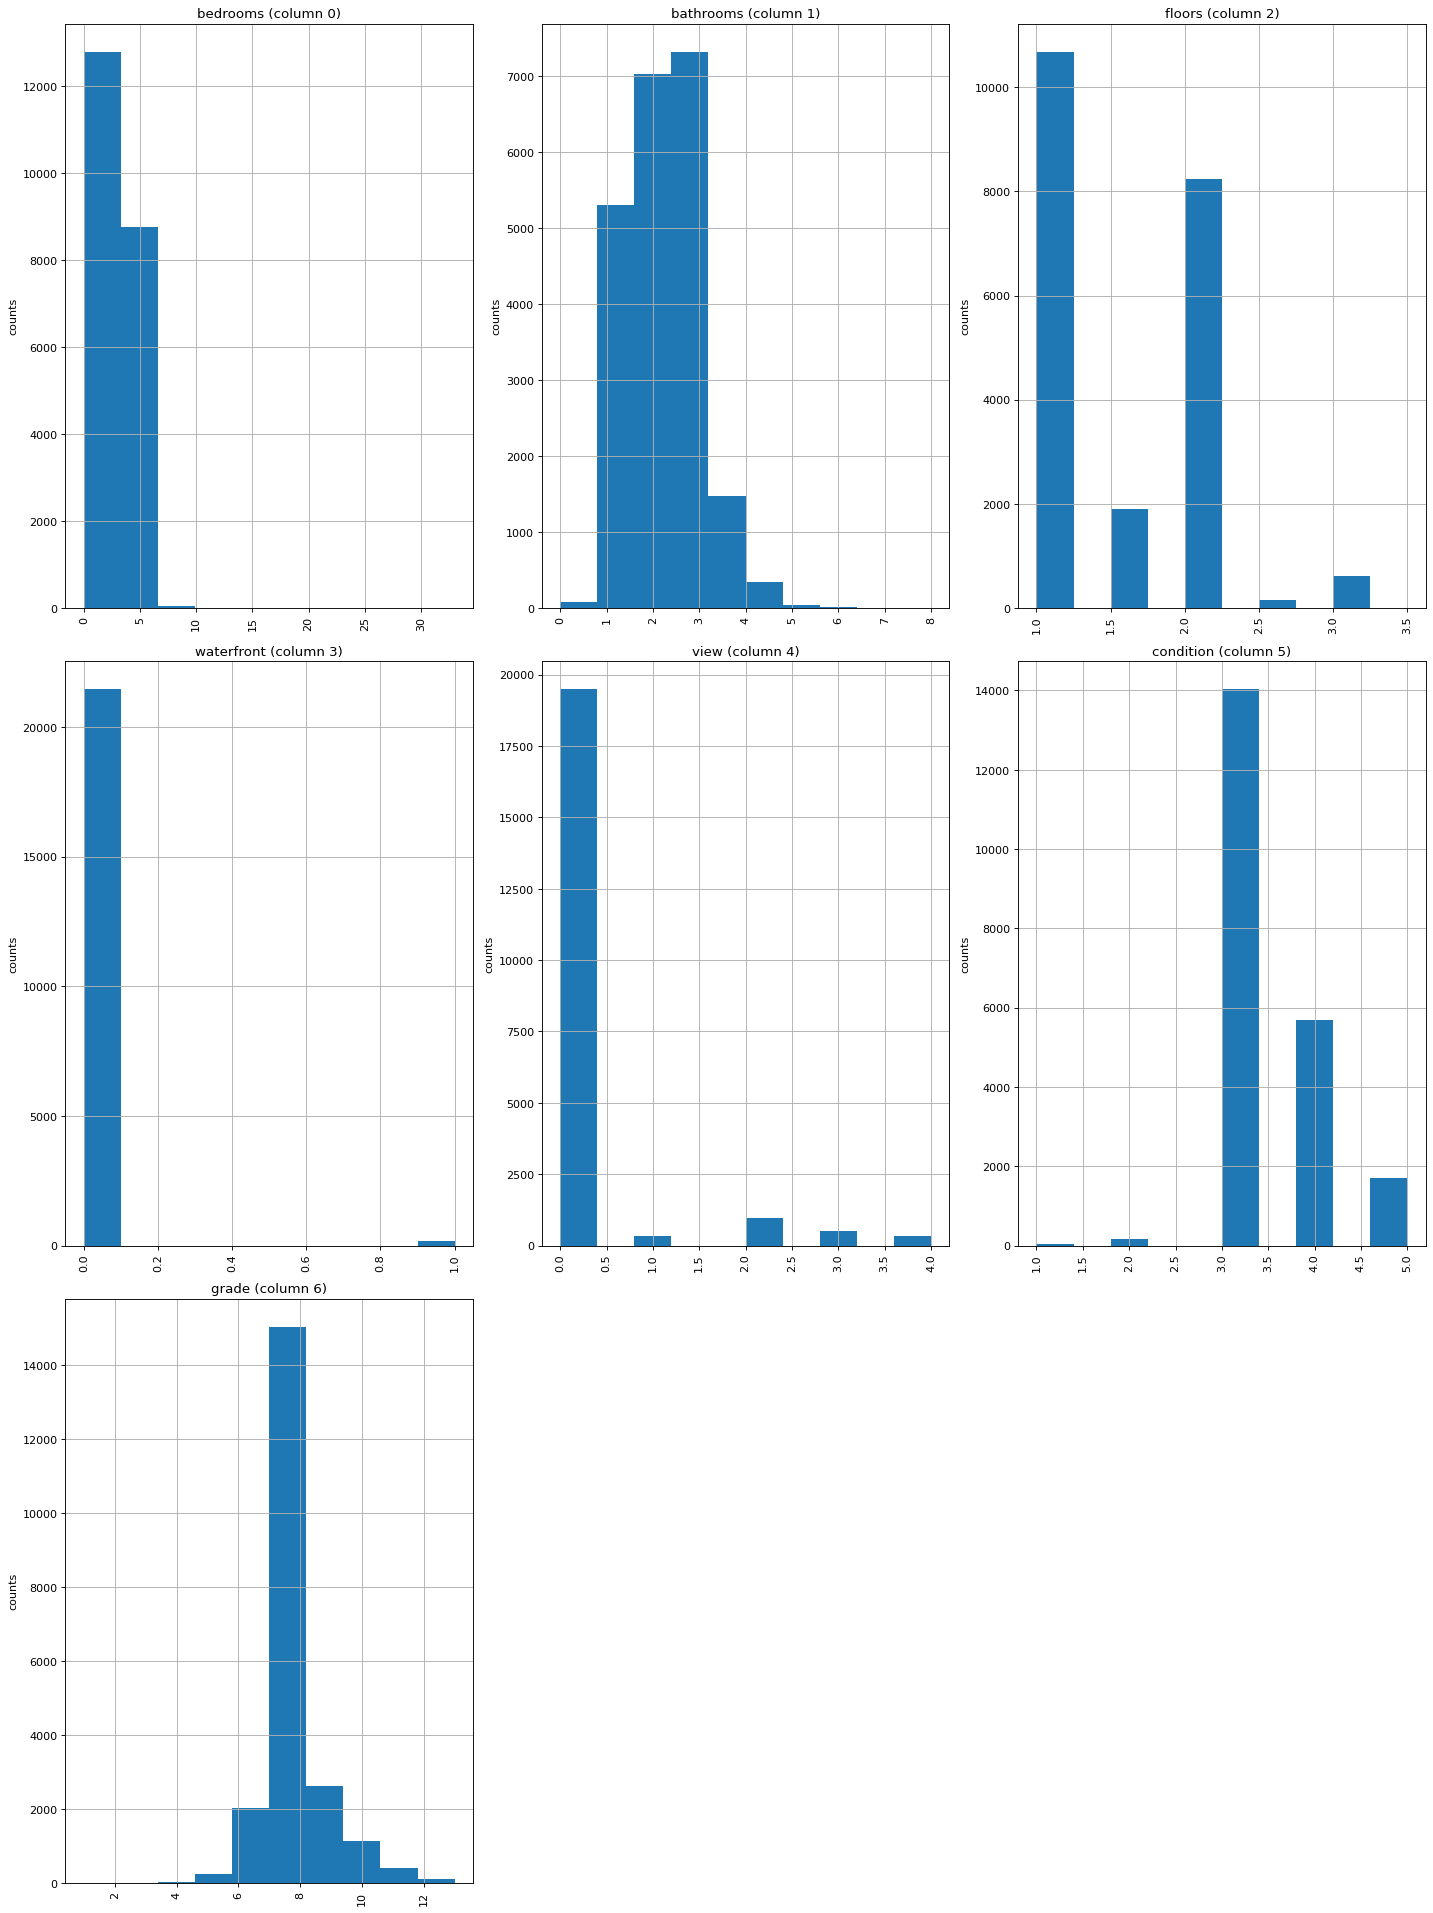

In [8]:
plotPerColumnDistribution(df,20,3)

In [7]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for the dataframe', fontsize=15)
    plt.show()

/tmp/ipykernel_938748/1774403282.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


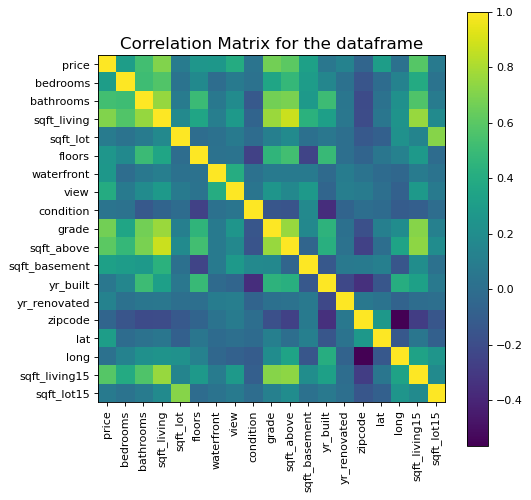

In [8]:
plotCorrelationMatrix(df, 7)

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


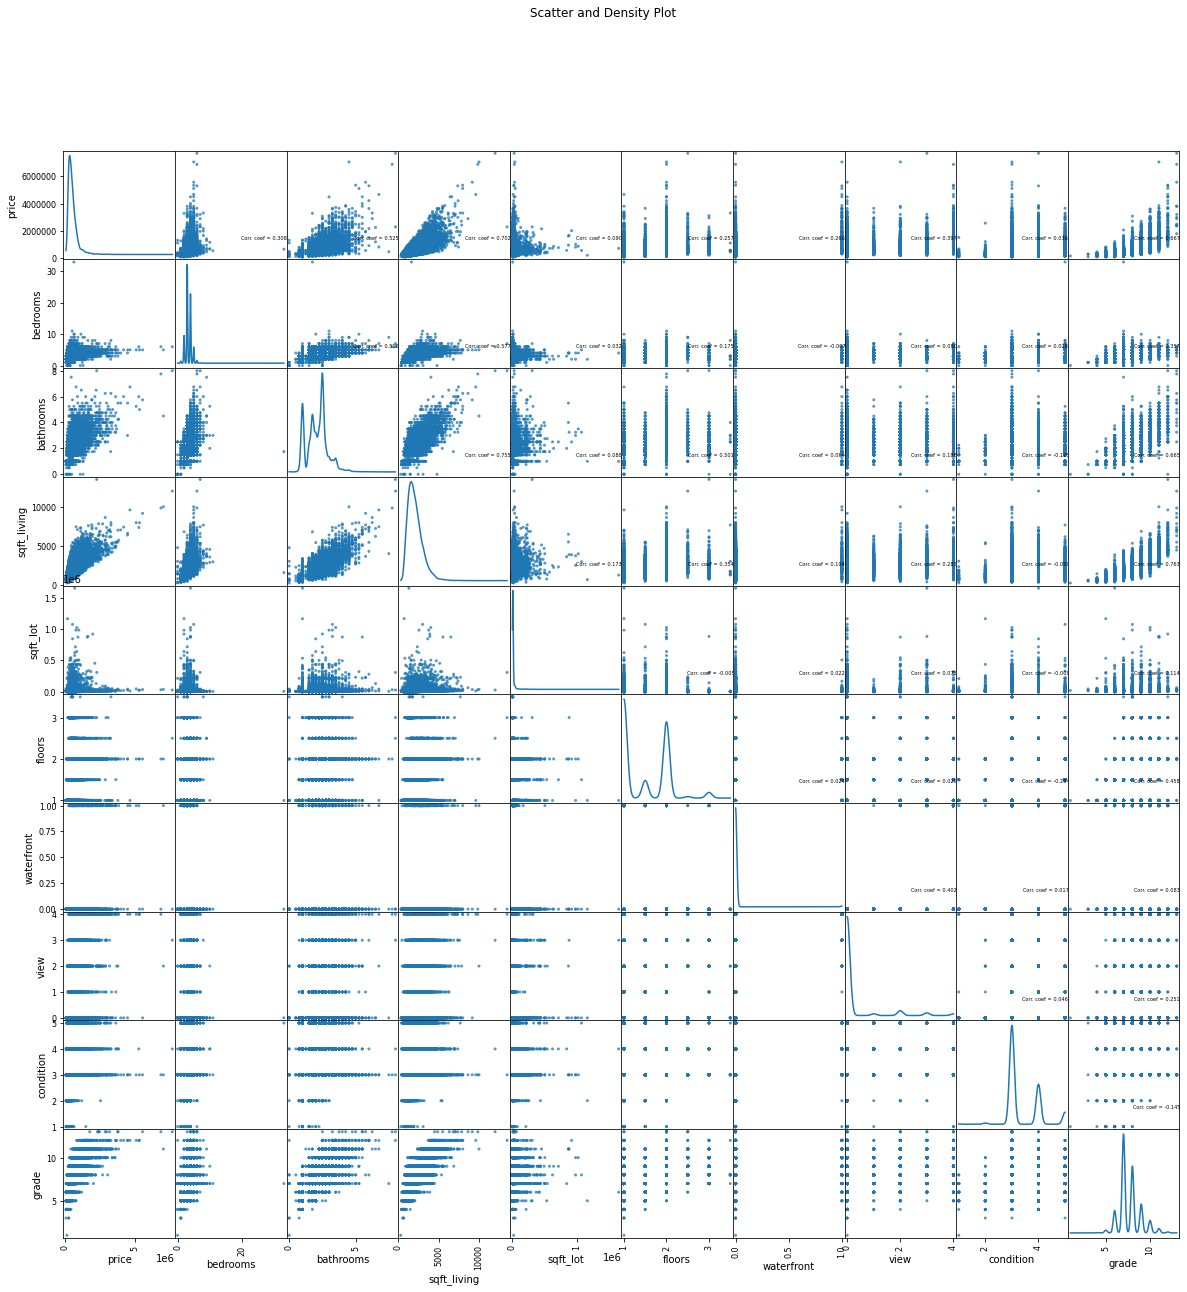

In [12]:
plotScatterMatrix(df, 20, 5)

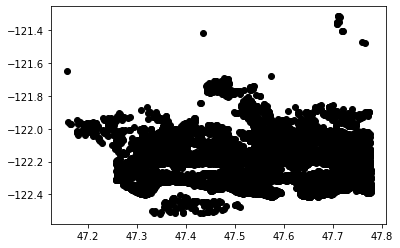

In [10]:
plt.plot(df.lat, df.long, 'o', color='black');

In [11]:
(df_train,df_test) = train_test_split(df,train_size = 0.8, test_size = 0.2, random_state = 0,shuffle = True)

In [12]:
X_train = df_train.iloc[:,2:]
X_test = df_test.iloc[:,2:]
y_train = df_train.iloc[:,1]
y_test = df_test.iloc[:,1]
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5268,3,1.00,1570,5510,1.0,0,0,4,7,1070,500,1940,0,98115,47.6942,-122.319,1770,6380
16909,3,2.50,1780,11000,1.0,0,0,4,8,1210,570,1980,0,98006,47.5574,-122.149,2310,9700
16123,3,1.50,1090,9862,1.0,0,0,3,8,1090,0,1987,0,98074,47.6256,-122.036,1710,9862
12181,4,2.50,2210,7079,2.0,0,0,3,8,2210,0,1993,0,98031,47.4206,-122.183,1970,7000
12617,3,2.50,1800,4763,2.0,0,0,3,7,1240,560,1985,0,98119,47.6460,-122.362,1790,4763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,5,5.00,3960,94089,2.0,0,0,3,10,3960,0,1998,0,98038,47.3800,-122.011,2240,64468
19648,2,2.50,1400,1262,2.0,0,0,3,8,1160,240,2008,0,98106,47.5342,-122.349,1060,1524
9845,3,2.25,2360,14950,1.0,0,0,4,9,2360,0,1978,0,98042,47.3856,-122.158,2720,14388
10799,4,2.00,2370,76665,2.0,0,0,4,8,2370,0,1978,0,98001,47.2831,-122.279,2110,19334


In [158]:
X_test.shape

(4323, 18)

In [13]:
X = df_train.drop(['price','date'],axis=1)
y = df_train.price

In [80]:
X_std = (X-X.mean())/X.std()

In [81]:
def biplot(X,n_comp,j1,j2,scale=1,alpha=0.25,s=50):
    
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    #X = (X-X.mean())/X.std()
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    cols = ['PC-'+str(i+1) for i in range(n_comp)]
    Z = pca.transform(X)
    Z = pd.DataFrame(Z,columns=cols)
    Z.plot.scatter(x=j1-1,y=j2-1,
                   alpha=alpha,
                   s=s,
                   figsize=(10,10))
    sd = np.sqrt(pca.explained_variance_)
    Zj1 = sd[j1-1]*np.array([1,0])
    Zj2 = sd[j2-1]*np.array([0,1])
    plt.arrow(0,0,Zj1[0],Zj1[1],head_width=0.1,color='k')
    plt.arrow(0,0,Zj2[0],Zj2[1],head_width=0.1,color='k')

    L = pca.components_
    L = pd.DataFrame(L,index=cols,columns=X.columns)
    for k in range(X.shape[1]):
        x = scale*L.iloc[j1-1,k]
        y = scale*L.iloc[j2-1,k]
        plt.arrow(0,0,x,y,head_width=0.1,color='r')
        plt.text(1.2*x,1.2*y,X.columns[k],color='black')
        plt.xlim([-3,3])
        plt.ylim([-3,3])
        
    PVE = pca.explained_variance_ratio_
    PVE = pd.Series(PVE,index=cols)
    return PVE

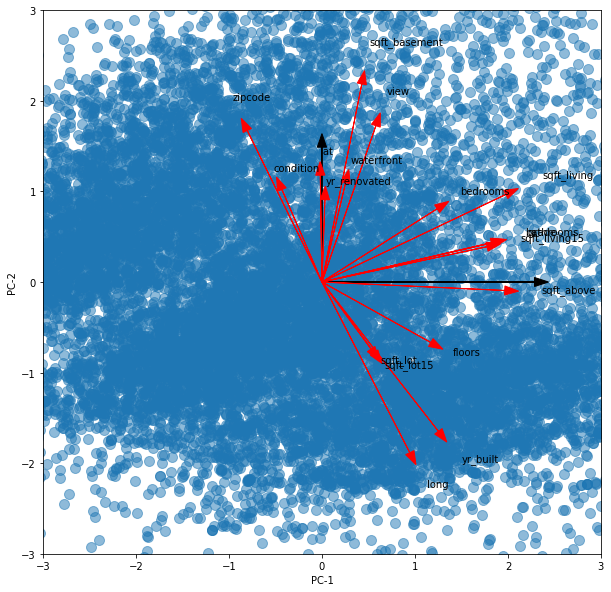

In [96]:
PVE = biplot(X_std,4,1,2,scale=5,alpha=0.5,s=100)

<AxesSubplot:>

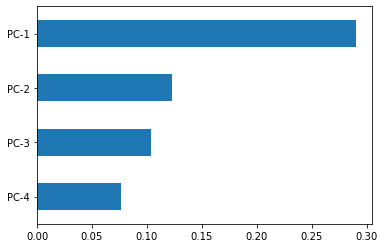

In [83]:
PVE.sort_values().plot.barh()

In [14]:
#SimpleBias Regressor for Baseline
def MAE(y,yh):
    return np.abs(y-yh).mean()

def MSE(y,yh):
    return np.abs((y-yh)**2).mean()
    
y.value_counts() 
ys = ((y - y.mean())/y.std()).round(3)
ys

5268    -0.128
16909    0.248
16123   -0.430
12181   -0.430
12617    0.342
         ...  
13123    1.711
19648   -0.655
9845    -0.300
10799   -0.354
2732     0.422
Name: price, Length: 17290, dtype: float64

In [15]:
def SimpleBiasRegressor(b,n):
    yh = b*np.ones(n)
    return yh

In [16]:
b = (np.mean(ys.round(3)))
yh = SimpleBiasRegressor(b,len(ys))
MSE(ys,yh)

0.9999483207591194

In [17]:
from sklearn.metrics import r2_score
B = np.linspace(ys.min(),ys.max(),10001)
mae = []
mse = []
R2 = []
Error = []
for b in B:
    yh = SimpleBiasRegressor(b,len(ys))
    mae.append(MAE(ys,yh))
    mse.append(MSE(ys,yh))
    R2.append(r2_score(ys,yh))
    Error.append(1-r2_score(ys,yh))

<AxesSubplot:xlabel='b'>

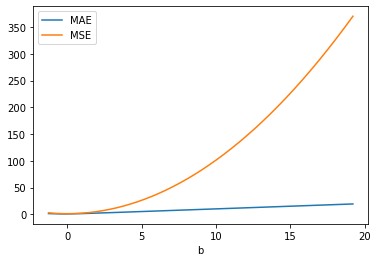

In [18]:
results = pd.DataFrame()
results['b'] = B
results['MAE'] = mae
results['MSE'] = mse
results['R2'] = R2
results['Error'] = Error
plot1 = results.plot.line(x = 'b', y = 'MAE')
results.plot.line(x='b', y='MSE', ax = plot1)

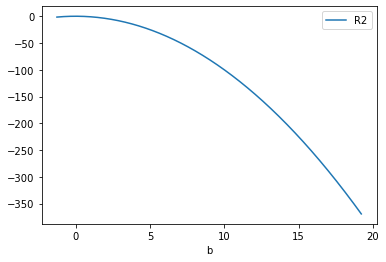

In [19]:
plot2 = results.plot.line(x = 'b', y = 'R2')

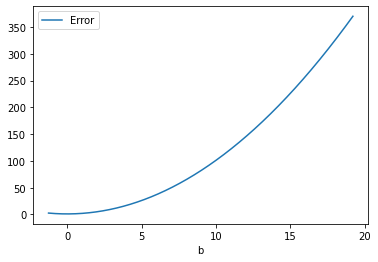

In [20]:
plot3 = results.plot.line(x = 'b', y = 'Error')

In [21]:
results

,b,MAE,MSE,R2,Error
0,-1.256000,1.255998,2.577479,-1.577612,2.577612
1,-1.253953,1.253951,2.572340,-1.572473,2.572473
2,-1.251905,1.251904,2.567210,-1.567343,2.567343
3,-1.249858,1.249857,2.562088,-1.562221,2.562221
4,-1.247811,1.247810,2.556975,-1.557107,2.557107
...,...,...,...,...,...
9996,19.208811,19.208814,369.978441,-368.997562,369.997562
9997,19.210858,19.210861,370.057097,-369.076223,370.076223
9998,19.212905,19.212908,370.135762,-369.154892,370.154892
9999,19.214953,19.214955,370.214436,-369.233569,370.233569


In [37]:
ix = results.R2.idxmax()
results.iloc[ix]

b       -0.001005
MAE      0.632094
MSE      0.999949
R2      -0.000001
Error    1.000001
Name: 613, dtype: float64

In [22]:
# decision tree - baseline regressor
grid = {'max_depth': np.arange(1,10)}

tree0 = DecisionTreeRegressor(max_depth=5)

In [23]:
tree0.fit(X,y)

DecisionTreeRegressor(max_depth=5)

In [24]:
# Baseline error rate - before outlier removal
print('Baseline train error rate 1-old: ', 1-tree0.score(X,y))

Baseline train error rate 1-old:  0.24154282344233913


In [25]:
# Baseline error rate - before outlier removal
print('Baseline test error rate 1-old: ', 1-tree0.score(X_test,y_test))

Baseline test error rate 1-old:  0.3120564340777041


In [26]:
# simple linear regressor - baseline regressor

In [109]:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

In [110]:
# Baseline error rate
print('Baseline train error rate 2-old: ', 1-lr.score(X,y))

Baseline train error rate 2-old:  0.2994650688855418


In [111]:
# Baseline error rate
print('Baseline valid error rate 2-old: ', 1-lr.score(X_test,y_test))

Baseline valid error rate 2-old:  0.3050689904882278


In [30]:
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [31]:
dot_data = export_graphviz(tree0,out_file=None,feature_names=X.columns,class_names=['pos','neg'],
                                proportion=True,impurity=False,filled=True, rounded=True)

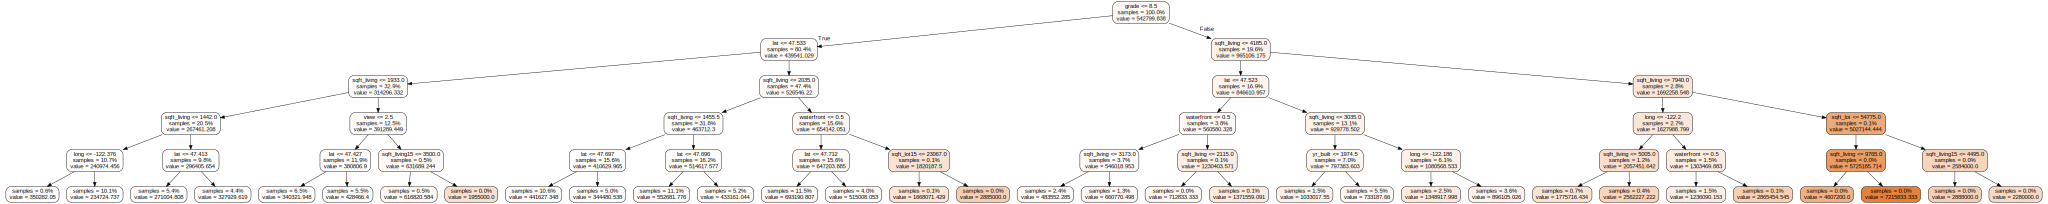

In [32]:
graph = graphviz.Source(dot_data)
graph

In [33]:
# Working FE with specific features only 
poly=PolynomialFeatures(2,interaction_only=True,include_bias=False)
Xe_train = poly.fit_transform(X_train)
Xe_test = poly.fit_transform(X_test)
cols = poly.get_feature_names(X_train.columns)
Xe_train = pd.DataFrame(Xe_train,columns=cols)
Xe_test = pd.DataFrame(Xe_test,columns=cols)
Xe_train


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode lat,zipcode long,zipcode sqft_living15,zipcode sqft_lot15,lat long,lat sqft_living15,lat sqft_lot15,long sqft_living15,long sqft_lot15,sqft_living15 sqft_lot15
0,3.0,1.00,1570.0,5510.0,1.0,0.0,0.0,4.0,7.0,1070.0,...,4.679516e+06,-1.200133e+07,173663550.0,6.259737e+08,-5833.906850,84418.734,3.042890e+05,-216504.63,-780395.220,11292600.0
1,3.0,2.50,1780.0,11000.0,1.0,0.0,0.0,4.0,8.0,1210.0,...,4.660911e+06,-1.197133e+07,226393860.0,9.506582e+08,-5809.088853,109857.594,4.613068e+05,-282164.19,-1184845.300,22407000.0
2,3.0,1.50,1090.0,9862.0,1.0,0.0,0.0,3.0,8.0,1090.0,...,4.670833e+06,-1.196856e+07,167706540.0,9.672058e+08,-5812.037722,81439.776,4.696837e+05,-208681.56,-1203519.032,16864020.0
3,4.0,2.50,2210.0,7079.0,2.0,0.0,0.0,3.0,8.0,2210.0,...,4.648689e+06,-1.197772e+07,193121070.0,6.862170e+08,-5793.991170,93418.582,3.319442e+05,-240700.51,-855281.000,13790000.0
4,3.0,2.50,1800.0,4763.0,2.0,0.0,0.0,3.0,7.0,1240.0,...,4.674978e+06,-1.200604e+07,175633010.0,4.673408e+08,-5830.059852,85286.340,2.269379e+05,-219027.98,-582810.206,8525770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5.0,5.00,3960.0,94089.0,2.0,0.0,0.0,3.0,10.0,3960.0,...,4.645040e+06,-1.196171e+07,219605120.0,6.320314e+09,-5780.881180,106131.200,3.054494e+06,-273304.64,-7865805.148,144408320.0
17286,2.0,2.50,1400.0,1262.0,2.0,0.0,0.0,3.0,8.0,1160.0,...,4.663390e+06,-1.200317e+07,103992360.0,1.495135e+08,-5815.761836,50386.252,7.244212e+04,-129689.94,-186459.876,1615440.0
17287,3.0,2.25,2360.0,14950.0,1.0,0.0,0.0,4.0,9.0,2360.0,...,4.645779e+06,-1.197661e+07,266674240.0,1.410628e+09,-5788.530125,128888.832,6.817840e+05,-332269.76,-1757609.304,39135360.0
17288,4.0,2.00,2370.0,76665.0,2.0,0.0,0.0,4.0,8.0,2370.0,...,4.633791e+06,-1.198346e+07,206782110.0,1.894751e+09,-5781.730185,99767.341,9.141715e+05,-258008.69,-2364142.186,40794740.0


In [34]:
Xe_train.shape


(17290, 171)

In [103]:
# Random Forests Regressor 
grid = {'n_estimators':np.arange(100,200,10)}

rf = RandomForestRegressor()
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)

In [104]:
rfCV.fit(Xe_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [105]:
rfCV.cv_results_

{'mean_fit_time': array([513.86947112, 554.00032616, 595.49877286, 625.27161684,
        680.21359987, 715.21498904, 761.71733189, 786.07250872,
        825.63351316, 849.16880202]),
 'std_fit_time': array([ 4.07920295, 26.87986732, 21.73539878, 28.69774028, 17.28418309,
        23.75493644,  7.19275381, 21.86693968,  4.41573363,  5.95891192]),
 'mean_score_time': array([0.7366075 , 0.81523385, 0.93289599, 0.93780618, 0.96829944,
        0.92094951, 0.86248569, 0.8776989 , 0.91237016, 1.0329205 ]),
 'std_score_time': array([0.05723587, 0.02784056, 0.08477392, 0.15271642, 0.19936919,
        0.20781278, 0.18945601, 0.11113779, 0.0953846 , 0.38863425]),
 'param_n_estimators': masked_array(data=[100, 110, 120, 130, 140, 150, 160, 170, 180, 190],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 100},
  {'n_estimators': 110},
  {'n_estimators': 120},

In [106]:
rfCV.best_score_

0.8541686210462645

In [107]:
rfCV.best_estimator_

RandomForestRegressor(n_estimators=140)

In [108]:
results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['Train R2'] = rfCV.cv_results_['mean_train_score']
results['Valid R2'] = rfCV.cv_results_['mean_test_score']
results

,trees,Train R2,Valid R2
0,100,0.979660,0.851783
1,110,0.980585,0.852444
2,120,0.980661,0.852126
3,130,0.980507,0.849674
4,140,0.980353,0.854169
5,150,0.980363,0.850682
6,160,0.980882,0.851634
7,170,0.980451,0.850752
8,180,0.980583,0.852233
9,190,0.980668,0.849386


In [157]:
yeh_test = rfCV.predict(Xe_test)
r2_score(yeh_test,y_test)

0.8613502244460342

In [114]:
# Gradient Boosting Regressor 
grid = {'learning_rate':[1,0.1,0.01,0.001],'n_estimators':np.arange(100,200,10)}

In [45]:


gbt = GradientBoostingRegressor()
gbtCV = GridSearchCV(gbt,param_grid=grid,return_train_score=True,n_jobs=-1)


In [46]:
gbtCV.fit(Xe_train,y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [47]:
gbtCV.cv_results_

{'mean_fit_time': array([1866.26787853, 2614.55270724, 3303.48540101, 3322.5165072 ,
        3342.99054093, 3359.83177199, 2814.74409852, 3391.86999369,
        3163.85309958, 3422.27328048, 2550.11928186, 3278.73865438,
        2815.54828782, 1463.87069969, 1054.81973963,  708.46648517,
         226.31526575,  290.51202617,  411.52134709,  412.1052793 ,
         187.07804627,  198.33911185,  229.4692101 ,  244.56029396,
         271.52197533,  313.21368351,  390.93041749,  421.94206805,
        1162.95266433, 1240.75644894,  209.69354348,  266.215308  ,
         491.48704681,  501.15855689, 1257.31152496, 1691.82630482,
        3097.77567163, 1784.2663908 ,  415.56987271, 2466.72282314]),
 'std_fit_time': array([ 704.6515309 ,  826.09688143,    4.47281873,    4.20153568,
           6.90986301,    5.00833493,  689.07789553,   25.82288695,
         512.60896716,   30.95504932,  856.4736485 ,    5.25143743,
         942.64291383,  444.74745124,  212.50396835,   60.87600776,
          70.

In [48]:
gbtCV.best_score_

0.8643221691609814

In [49]:
gbtCV.best_params_

{'learning_rate': 0.1, 'n_estimators': 190}

<AxesSubplot:xlabel='setup'>

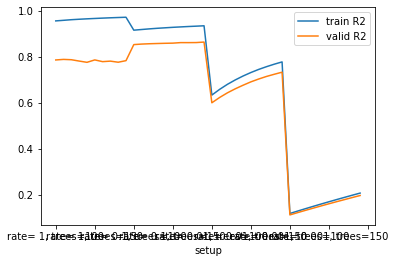

In [116]:
results = pd.DataFrame()
results['setup'] =  [y +", trees="+ str(z) for y in ["rate= "+ str(x) for x in grid['learning_rate']] for z in grid['n_estimators']]
results['train R2'] = gbtCV.cv_results_['mean_train_score']
results['valid R2']  = gbtCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='setup',y='train R2')
results.plot.line(x='setup',y='valid R2',ax=ax1)

In [59]:
results

,setup,train R2,valid R2
0,"rate= 1, trees=100",0.956558,0.786370
1,"rate= 0.1, trees=100",0.959111,0.788815
2,"rate= 0.01, trees=100",0.961767,0.787417
3,"rate= 0.001, trees=100",0.963771,0.781540
4,"rate= 1, trees=110",0.965571,0.776096
5,"rate= 0.1, trees=110",0.967163,0.786576
6,"rate= 0.01, trees=110",0.968690,0.779049
7,"rate= 0.001, trees=110",0.970098,0.781274
8,"rate= 1, trees=120",0.971314,0.776499
9,"rate= 0.1, trees=120",0.972491,0.783352


In [156]:
yeh_test = gbtCV.predict(Xe_test)
r2_score(yeh_test,y_test)

0.8689813527358684

In [60]:
def DecisionBoundary(clf,feature_names,target_name,df):
    
    from sklearn.preprocessing import StandardScaler,LabelEncoder
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    N     = 250   # N x N number of points for 2D grid generation
    alpha = 0.2   # point transparency
    pt_size = 200
    sns.set_palette('bright')
    cmap = sns.color_palette('bright')

    # create 2D grid of points in feature space
    X1 = df[feature_names[0]]
    X2 = df[feature_names[1]]
    XX1,XX2 = np.meshgrid(
    np.linspace(X1.min(),X1.max(),N),
    np.linspace(X2.min(),X2.max(),N))
    
    # integer code categories
    df['target_code'] = LabelEncoder().fit_transform(df[target_name])
    
    # shuffle and stratified-split data
    (df_train,df_test) = train_test_split(df,
                                          train_size=0.8,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=df[target_name],
                                          random_state=0)
    
    # assign features and targets
    features_train = df_train[feature_names]
    features_test  = df_test[feature_names]
    target_train   = df_train['target_code']
    target_test    = df_test['target_code']
    
    # standardize
    stnd = StandardScaler()
    stnd.fit(features_train)
    features_train = stnd.transform(features_train)
    features_test  = stnd.transform(features_test)
    
    # fit classifier
    clf.fit(features_train,target_train)
    
    # predict targets on 2D grid
    features_grid = np.stack([XX1.ravel(),XX2.ravel()],axis=1)
    features_grid = stnd.transform(features_grid)
    Y = clf.predict(features_grid)
    YY = Y.reshape(XX1.shape)
    
    
    # plot train set
    fig1,ax1 = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=feature_names[0],
                    y=feature_names[1],
                    hue=target_name,
                    data=df_train,
                    s=pt_size,
                    ax=ax1)
    plt.contourf(XX1,XX2,YY,alpha=alpha,colors=cmap)
    plt.title('train set')
    
    # plot test set
    fig2,ax2 = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=feature_names[0],
                          y=feature_names[1],
                          hue=target_name,
                          data=df_test,
                          s=pt_size,
                          ax=ax2)
    plt.contourf(XX1,XX2,YY,alpha=alpha,colors=cmap)
    plt.title('test set')
    
    error_train = 1 - clf.score(features_train,target_train)
    error_test  = 1 - clf.score(features_test,target_test)
    
    return error_train, error_test


In [69]:
from sklearn.svm  import SVC
from sklearn.model_selection import cross_validate

In [65]:
clf_rbf = SVC(C=1, kernel='rbf', gamma=10)

In [66]:
clf_rbf.fit(Xe_train,y_train)

SVC(C=1, gamma=10)

In [ ]:
cv_results = cross_validate(clf_rbf,Xe_train,y_train,return_train_score=True)

In [ ]:
training_score = cv_results['train_score'].mean()
validation_score   = cv_results['test_score'].mean()

In [ ]:
print('SVM: Radial Basis Function')
print('      training score:',training_score)
print('    validation score:',validation_score)

In [71]:
Xf_train = X_train.drop(['bedrooms','bathrooms','floors','waterfront','view','condition','sqft_basement','zipcode'],axis=1)
Xn_train = X_train.drop(['sqft_living','sqft_lot','grade','sqft_above','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15'],axis=1)
Xf_test = X_test.drop(['bedrooms','bathrooms','floors','waterfront','view','condition','sqft_basement','zipcode'],axis=1)
Xn_test = X_test.drop(['sqft_living','sqft_lot','grade','sqft_above','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15'],axis=1)
poly=PolynomialFeatures(2,interaction_only=True,include_bias=False)
Xa_train = poly.fit_transform(Xf_train)
Xa_test = poly.fit_transform(Xf_test)
cols = poly.get_feature_names(Xf_train.columns)
Xer_train = pd.DataFrame(Xa_train,columns=cols)
Xer_test = pd.DataFrame(Xa_test,columns=cols)

Xer_train

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,sqft_living,sqft_lot,grade,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,...,yr_renovated lat,yr_renovated long,yr_renovated sqft_living15,yr_renovated sqft_lot15,lat long,lat sqft_living15,lat sqft_lot15,long sqft_living15,long sqft_lot15,sqft_living15 sqft_lot15
0,1570.0,5510.0,7.0,1070.0,1940.0,0.0,47.6942,-122.319,1770.0,6380.0,...,0.0,-0.0,0.0,0.0,-5833.906850,84418.734,3.042890e+05,-216504.63,-780395.220,11292600.0
1,1780.0,11000.0,8.0,1210.0,1980.0,0.0,47.5574,-122.149,2310.0,9700.0,...,0.0,-0.0,0.0,0.0,-5809.088853,109857.594,4.613068e+05,-282164.19,-1184845.300,22407000.0
2,1090.0,9862.0,8.0,1090.0,1987.0,0.0,47.6256,-122.036,1710.0,9862.0,...,0.0,-0.0,0.0,0.0,-5812.037722,81439.776,4.696837e+05,-208681.56,-1203519.032,16864020.0
3,2210.0,7079.0,8.0,2210.0,1993.0,0.0,47.4206,-122.183,1970.0,7000.0,...,0.0,-0.0,0.0,0.0,-5793.991170,93418.582,3.319442e+05,-240700.51,-855281.000,13790000.0
4,1800.0,4763.0,7.0,1240.0,1985.0,0.0,47.6460,-122.362,1790.0,4763.0,...,0.0,-0.0,0.0,0.0,-5830.059852,85286.340,2.269379e+05,-219027.98,-582810.206,8525770.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,3960.0,94089.0,10.0,3960.0,1998.0,0.0,47.3800,-122.011,2240.0,64468.0,...,0.0,-0.0,0.0,0.0,-5780.881180,106131.200,3.054494e+06,-273304.64,-7865805.148,144408320.0
17286,1400.0,1262.0,8.0,1160.0,2008.0,0.0,47.5342,-122.349,1060.0,1524.0,...,0.0,-0.0,0.0,0.0,-5815.761836,50386.252,7.244212e+04,-129689.94,-186459.876,1615440.0
17287,2360.0,14950.0,9.0,2360.0,1978.0,0.0,47.3856,-122.158,2720.0,14388.0,...,0.0,-0.0,0.0,0.0,-5788.530125,128888.832,6.817840e+05,-332269.76,-1757609.304,39135360.0
17288,2370.0,76665.0,8.0,2370.0,1978.0,0.0,47.2831,-122.279,2110.0,19334.0,...,0.0,-0.0,0.0,0.0,-5781.730185,99767.341,9.141715e+05,-258008.69,-2364142.186,40794740.0


In [72]:
gbtCV2 = GridSearchCV(gbt,param_grid=grid,return_train_score=True,n_jobs=-1)

In [75]:
gbtCV2.fit(Xer_train,y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [163]:
gbtCV2.best_score_

0.8193217708042615

In [77]:
gbtCV2.best_params_

{'learning_rate': 0.1, 'n_estimators': 180}

<AxesSubplot:xlabel='setup'>

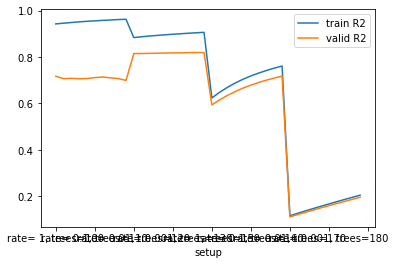

In [78]:
results = pd.DataFrame()
results['setup'] =  [y +", trees="+ str(z) for z in grid['n_estimators'] for y in ["rate= "+ str(x) for x in grid['learning_rate']]]
results['train R2'] = gbtCV2.cv_results_['mean_train_score']
results['valid R2']  = gbtCV2.cv_results_['mean_test_score']
ax1 = results.plot.line(x='setup',y='train R2')
results.plot.line(x='setup',y='valid R2',ax=ax1)

In [79]:
results

,setup,train R2,valid R2
0,"rate= 1, trees=100",0.942445,0.717221
1,"rate= 0.1, trees=100",0.945604,0.706889
2,"rate= 0.01, trees=100",0.948498,0.708141
3,"rate= 0.001, trees=100",0.951437,0.706442
4,"rate= 1, trees=110",0.953676,0.707122
5,"rate= 0.1, trees=110",0.955702,0.711349
6,"rate= 0.01, trees=110",0.957644,0.713879
7,"rate= 0.001, trees=110",0.959304,0.710168
8,"rate= 1, trees=120",0.961177,0.707169
9,"rate= 0.1, trees=120",0.962601,0.699228


In [98]:
grid = {'n_estimators':np.arange(100,200,10)}
rfCV2 = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV2.fit(Xer_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             return_train_score=True)

In [161]:
rfCV2.best_score_

0.8174944095556519

In [162]:
rfCV2.best_params_

{'n_estimators': 120}

In [159]:
results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['Train R2'] = rfCV2.cv_results_['mean_train_score']
results['Valid R2'] = rfCV2.cv_results_['mean_test_score']
results

,trees,Train R2,Valid R2
0,100,0.976375,0.815644
1,110,0.976318,0.815677
2,120,0.976404,0.817494
3,130,0.976352,0.815302
4,140,0.976624,0.815740
5,150,0.976924,0.816424
6,160,0.976572,0.815242
7,170,0.976654,0.816973
8,180,0.976860,0.816769
9,190,0.976745,0.816430


In [143]:
def demo_Prediction(loc,model):
    call = Xe_test.loc[loc].to_numpy().reshape(1,-1)
    value = pd.DataFrame(call)
    target = y_test.iloc[loc]
    result = model.predict(value)[0]
    print("----------------------------")
    print("Predicted Price", result )
    print("Actual Price", target)
    print("Abs Diff", abs(result-target))
    print("----------------------------")
    return abs(result-target)

In [132]:
y_test.shape

(4323,)

In [150]:
import random
randomlist = []
for i in range(0,7):
    n = random.randint(1,y_test.shape[0])
    randomlist.append(n)
print(randomlist)

[1015, 1167, 3402, 1433, 2766, 1950, 3424]


In [151]:
def demo_five_predictions(locs,model):
    count = 0
    total = 0
    for loc in locs:
        diff = demo_Prediction(loc,model)
        total = total + diff
        count = count + 1
    print("Total Diff", total )
    print("Avearge Diff", total/count)

In [152]:
demo_five_predictions(randomlist,rfCV)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


----------------------------
Predicted Price 522272.85
Actual Price 665000.0
Abs Diff 142727.15000000002
----------------------------
----------------------------
Predicted Price 836127.3
Actual Price 795000.0
Abs Diff 41127.30000000005
----------------------------
----------------------------
Predicted Price 581484.9214285715
Actual Price 610000.0
Abs Diff 28515.078571428545
----------------------------


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


----------------------------
Predicted Price 485832.8142857143
Actual Price 485000.0
Abs Diff 832.8142857142957
----------------------------
----------------------------
Predicted Price 804280.05
Actual Price 805000.0
Abs Diff 719.9499999999534
----------------------------
----------------------------
Predicted Price 1092070.7
Actual Price 870000.0
Abs Diff 222070.69999999995
----------------------------
----------------------------
Predicted Price 458520.5
Actual Price 426000.0
Abs Diff 32520.5
----------------------------
Total Diff 468513.4928571428
Avearge Diff 66930.49897959184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [153]:
demo_five_predictions(randomlist,gbtCV)

----------------------------
Predicted Price 550976.7227956562
Actual Price 665000.0
Abs Diff 114023.27720434382
----------------------------
----------------------------
Predicted Price 898896.7085403095
Actual Price 795000.0
Abs Diff 103896.70854030945
----------------------------
----------------------------
Predicted Price 626002.2798567081
Actual Price 610000.0
Abs Diff 16002.279856708134
----------------------------
----------------------------
Predicted Price 495136.83397659997
Actual Price 485000.0
Abs Diff 10136.83397659997
----------------------------
----------------------------
Predicted Price 801388.7205108649
Actual Price 805000.0
Abs Diff 3611.279489135137
----------------------------
----------------------------
Predicted Price 879494.9789232364
Actual Price 870000.0
Abs Diff 9494.97892323637
----------------------------
----------------------------
Predicted Price 491827.6456557862
Actual Price 426000.0
Abs Diff 65827.64565578621
----------------------------
Total Diff

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sk